In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
from scipy.integrate import solve_ivp
from function_list import *
plt.rcParams['text.usetex'] = True

### Tutorial 2: Question 5
We seek to solve the following boundary value problem 
\begin{equation}
yy''+(y')^2 + 1 = 0, \quad y(1)=1, \quad y(2)=0
\end{equation}
using the Newton-Kantorovich method.

Expressing the boundary value problem as
\begin{equation}
F(y)=
\begin{cases}
y''+\frac{(y')^2}{y}+\frac{1}{y}=0 \\
y(1)-1=0 \\
y(2) = 0
\end{cases}
\end{equation}

The Fréchet derivative is
\begin{equation}
F'(z)=
\begin{cases}
z''-\frac{z(y')^2}{y^2} + \frac{2y'z'}{y}-\frac{z}{y^2} \\
z(1) = 0 \\
z(2) = 0
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F'z=-F$ is
\begin{align}
z''-\frac{z(y')^2}{y^2} + \frac{2y'z'}{y}-\frac{z}{y^2} &= -\left[ y''+\frac{(y')^2}{y}+\frac{1}{y} \right] \\
z(1) &= -\left[ y(1)-1 \right] \\
z(2) &= -y(2)
\end{align}

We now want to solve this system using finite differences. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N+1$ points and $N$ spacings between those points of width $h$.

In [2]:
a, b = [1, 2] # [start point, end point]
N = 100 # number of points
h = (b-a)/N # space width
x = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

Substituting centered finite differences into the Newton-Kantorovich method
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} - z_j\left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2\frac{1}{y_j^2}+2\left(\frac{y_{j+1}-y_{j-1}}{2h}\right)\left(\frac{z_{j+1}-z_{j-1}}{2h}\right)\frac{1}{y_j} - z_j\frac{1}{y_j^2} &= -\left[\frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2\frac{1}{y_j} + \frac{1}{y_j}\right] \\
z_1 &= -y_1 + 1 \\
z_{N+1} &= -y_{N+1}
\end{align}

Factoring the left hand side in terms of $z$
\begin{align}
z_{j-1}\left[\frac{1}{h^2} -\frac{1}{h} \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)\frac{1}{y_j} \right] + z_j \left[ -\frac{2}{h^2} - \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2\frac{1}{y_j^2}-\frac{1}{y_j^2}\right] + z_{j+1}\left[\frac{1}{h^2} + \frac{1}{h}\left(\frac{y_{j+1}-y_{j-1}}{2h}\right)\frac{1}{y_j}\right] &= -\left[\frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \left(\frac{y_{j+1}-y_{j-1}}{2h}\right)^2\frac{1}{y_j} + \frac{1}{y_j}\right] \\
z_1 &= -y_1 + 1 \\
z_{N+1} &= -y_{N+1}
\end{align}

We can now express $F'$ as a Jacobian matrix

In [3]:
def jacobian_f(N, x, y, h):
    jacobian = np.zeros((N+1, N+1)) # creates an N+1 by N+1 dimension array
    
    jacobian[(0, 0)] = 1 # first element of the Jacobian matrix
    
    jacobian[(N, N)] = 1 # last element of the Jacobian matrix
    
    diag_1 = []
    diag_2 = []
    diag_3 = []

    for i in range(1, N):
        diag_1.append((1/(h**2)) - (1/h)*((y[i+1] - y[i-1])/(2*h))*(1/y[i]))
        diag_2.append(-(2/(h**2))-(((y[i+1] - y[i-1])/(2*h))**2)*(1/y[i]**2)-(1/y[i]**2))
        diag_3.append((1/(h**2)) + (1/h)*((y[i+1] - y[i-1])/(2*h))*(1/y[i]))

    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Similarly, we can express $-F$ as a vector to solve $F'z=-F$

In [4]:
def vec_f(N, x, y, h):
    A = np.zeros(N + 1)
    
    A[0] = -y[0]+1
    A[N] = -y[N]

    for i in range(1, N):
        A[i] = (-(y[i-1]-2*y[i]+y[i+1])/(h**2) - (((y[i+1] - y[i-1])/(2*h))**2)*(1/y[i]) - (1/y[i]))

    return A

We can now create a while loop to iteratively solve for $\vec{y}$ with corrections $\vec{z}$

In [5]:
def newton_kantorovich_method_f(N, x, y, h, tol=10**(-6)):
    n_iterations = 0
    A = vec_f(N, x, y, h)

    while norm(A) > tol and n_iterations < 100:
        jacobian = jacobian_f(N, x, y, h)
        z = solve(jacobian, A)
        y = y + z
        A = vec_f(N, x, y, h)
        n_iterations = n_iterations + 1

    return [y, n_iterations]

We can test this using the ansatz
\begin{equation}
y(x) = \frac{1}{1+x^2}
\end{equation}

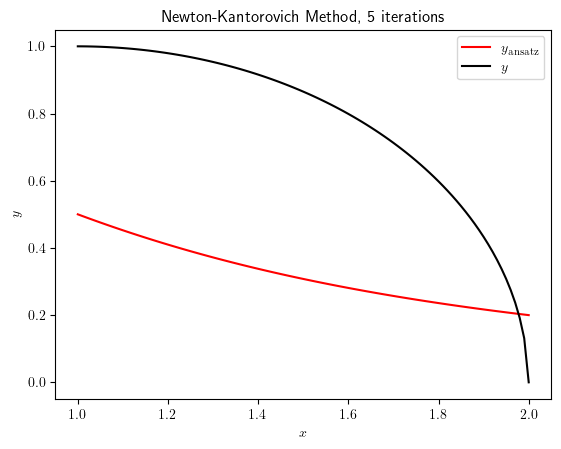

In [6]:
y_ansatz = 1/(1+x**2)
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h)
plot_f(x, y_ansatz, y, n_iterations, 'x', 'y')